In [10]:
import duckdb
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import plotly.express as px

# Connect to DuckDB
DB_NAME = "amazing.duckdb"
con = duckdb.connect(DB_NAME)

# Step 1: Create User-Item Matrix
print("Creating User-Item Matrix...")
query = """
    SELECT user_id, product_id, COUNT(*) AS interactions
    FROM all_events
    WHERE event_type IN ('view', 'purchase')
    GROUP BY user_id, product_id
"""
user_item = con.execute(query).fetch_df()
user_item_df = user_item.head(10000)

Creating User-Item Matrix...


In [11]:
# Pivot the data to create a User-Item matrix
user_item_matrix = user_item_df.pivot(index='user_id', columns='product_id', values='interactions').fillna(0)

In [12]:
user_item_matrix.shape

(9637, 5849)

In [13]:
# Step 2: Dimensionality Reduction (Optional)
print("Applying PCA for dimensionality reduction...")
pca = PCA(n_components=50)  # Reduce to 50 dimensions
user_item_reduced = pca.fit_transform(user_item_matrix)

Applying PCA for dimensionality reduction...


In [14]:
user_item_reduced.shape


(9637, 50)

In [15]:
# Step 3: Clustering
print("Clustering users...")
ks = range(2, 11)
silhouette_scores = []
calinski_harabasz_scores = []
davies_bouldin_scores = []

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(user_item_reduced)
    
    # Compute metrics
    silhouette_scores.append(silhouette_score(user_item_reduced, clusters))
    calinski_harabasz_scores.append(calinski_harabasz_score(user_item_reduced, clusters))
    davies_bouldin_scores.append(davies_bouldin_score(user_item_reduced, clusters))


Clustering users...


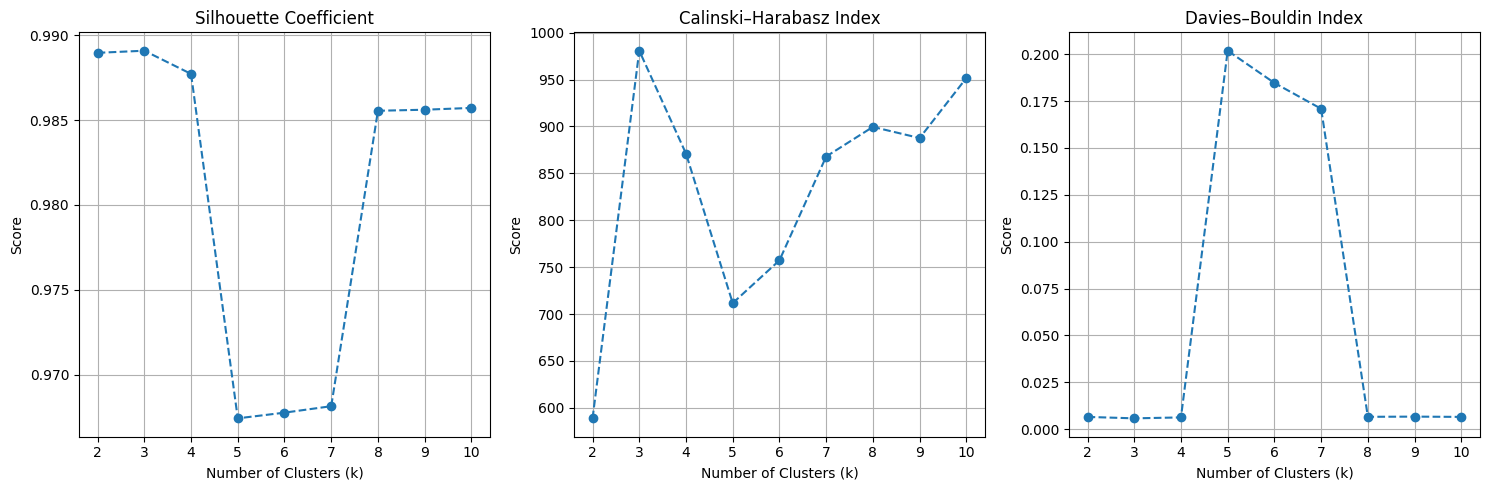

Top 1000 users who are very much similar to the User- 778 are: 
1 . User: 778 separated by distance of 0.0
2 . User: 522 separated by distance of 0.0
3 . User: 6626 separated by distance of 1.0
4 . User: 7173 separated by distance of 1.0
5 . User: 7172 separated by distance of 1.0
6 . User: 7171 separated by distance of 1.0
7 . User: 7170 separated by distance of 1.0
8 . User: 7169 separated by distance of 1.0
9 . User: 7168 separated by distance of 1.0
10 . User: 7167 separated by distance of 1.0
11 . User: 7166 separated by distance of 1.0
12 . User: 7165 separated by distance of 1.0
13 . User: 7164 separated by distance of 1.0
14 . User: 7163 separated by distance of 1.0
15 . User: 7162 separated by distance of 1.0
16 . User: 7161 separated by distance of 1.0
17 . User: 7160 separated by distance of 1.0
18 . User: 7159 separated by distance of 1.0
19 . User: 7158 separated by distance of 1.0
20 . User: 7157 separated by distance of 1.0
21 . User: 7156 separated by distance of 1.0
22

In [16]:
# Step 4: Plot Metrics
plt.figure(figsize=(15, 5))

# Silhouette Coefficient
plt.subplot(1, 3, 1)
plt.plot(ks, silhouette_scores, marker='o', linestyle='--')
plt.title("Silhouette Coefficient")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Score")
plt.grid(True)

# Calinski–Harabasz Index
plt.subplot(1, 3, 2)
plt.plot(ks, calinski_harabasz_scores, marker='o', linestyle='--')
plt.title("Calinski–Harabasz Index")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Score")
plt.grid(True)

# Davies–Bouldin Index
plt.subplot(1, 3, 3)
plt.plot(ks, davies_bouldin_scores, marker='o', linestyle='--')
plt.title("Davies–Bouldin Index")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Score")
plt.grid(True)

plt.tight_layout()
plt.show()

# Backup the original User-Item matrix
original_user_item_matrix = user_item_matrix.copy()

# Train the KNN model
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(original_user_item_matrix.values)

# Apply KMeans clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(original_user_item_matrix.values)

kmeans = KMeans(n_clusters=5, random_state=42)
user_clusters = kmeans.fit_predict(scaled_data)

# Add cluster labels to the DataFrame
user_item_matrix['Cluster'] = user_clusters

# Define the function to get similar users
def get_similar_users3d(user, n=5):
    knn_input = np.asarray([original_user_item_matrix.values[user - 1]])
    distances, indices = knn_model.kneighbors(knn_input, n_neighbors=n + 1)

    print("Top", n, "users who are very much similar to the User-", user, "are: ")
    for i in range(1, len(distances[0])):
        print(i, ". User:", indices[0][i] + 1, "separated by distance of", distances[0][i])
    return indices.flatten()[1:] + 1, distances.flatten()[1:]

# Define the 3D visualization function
def visualize_clusters_3d(user_id, user_item_matrix, user_clusters, similar_user_list):
    data_matrix = original_user_item_matrix.values

    # Reduce dimensions with PCA
    pca = PCA(n_components=3)
    reduced_data = pca.fit_transform(data_matrix)

    # Create a DataFrame for visualization
    cluster_df = pd.DataFrame(reduced_data, columns=["PCA1", "PCA2", "PCA3"])
    cluster_df["Cluster"] = user_clusters
    cluster_df["user_id"] = user_item_matrix.index

    # Add user type information
    cluster_df["type"] = "Other Users"
    cluster_df.loc[user_id - 1, "type"] = "Input User"
    for sim_user in similar_user_list:
        cluster_df.loc[sim_user - 1, "type"] = "Similar Users"

    # Create the 3D plot
    fig = px.scatter_3d(
        cluster_df,
        x="PCA1",
        y="PCA2",
        z="PCA3",
        color="Cluster",
        symbol="type",
        size=cluster_df["type"].apply(lambda x: 10 if x == "Input User" else 5),
        title="3D Representation of User Clusters",
        labels={"Cluster": "User Cluster"},
        hover_data=["user_id"]
    )

    fig.show()

# Example Inputs
user_id = 778
sim_users = 1000

# Get similar users
similar_user_list, distance_list = get_similar_users3d(user_id, sim_users)

# Visualize clusters in 3D
visualize_clusters_3d(user_id, user_item_matrix, user_clusters, similar_user_list)

# Step 5: Save Clustering Results
optimal_k = 4  # Choose the optimal number of clusters based on the metrics
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
user_item_matrix['cluster'] = kmeans.fit_predict(user_item_reduced)

